# Imports & Definitions
```
$ pip freeze
tensorflow
scikit-image
scikit-learn
imutils
opencv-python
```

In [1]:
import tensorflow
from tensorflow import keras
import numpy
import skimage.io as scikit_io
import skimage.transform as scikit_transform
import matplotlib.pyplot as matplot_plot
import matplotlib.image as matplot_image
import sklearn.model_selection as scikit_model_selection
import os
import random
import imutils
from imutils import paths
import seaborn

LEARNING_RATE = 0.0001
EPOCHS = 50
BATCH_SIZE = 16

INPUT_SIZE = 128
CHANNELS = 3

# Image Loading

In [2]:
        def load_image(path):
            image = scikit_io.imread(path)
            return scikit_transform.resize(image, (INPUT_SIZE, INPUT_SIZE), anti_aliasing = True)

        def show_image(image):
            matplot_plot.imshow(image)
            matplot_plot.axis('off')

In [3]:
datasource_dir = "../image-puller/images/"
dataset_dir = "images/"
labels = ["men", "women"]

random.seed(1)
test_train_ratio = 0.2

# Copy images from source into split directories of train / test for the given label
def prepare_directory(source, label):
    for image_path in os.listdir(source):
        if (image_path.endswith(".jpg")):
            try:
                image_set = "test" if random.random() < test_train_ratio else "train"
                destination = os.path.join(dataset_dir, image_set, label, image_path.replace(".jpg", ".png"))
                scikit_io.imsave(destination, load_image(os.path.join(source, image_path)))
            except:
                pass
def prepare(label):
    prepare_directory(os.path.join(datasource_dir, label), label)
            

# Prepare Dataset

In [4]:
# Make the directories
for split_dir in ["train/", "test/"]:
    for label in labels:
        os.makedirs(dataset_dir + split_dir + label + "/", exist_ok = True)

# Copy the images over
prepare("men")
prepare("women")


arning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. 

# Compile the images into training, testing and validation sets

In [4]:
def compile(images):
    dataset = numpy.ndarray((len(images), INPUT_SIZE, INPUT_SIZE, CHANNELS), dtype = numpy.uint8)
    labels = numpy.ndarray((len(images)), dtype = numpy.uint8)
    for index, image in enumerate(images):
        image_data = scikit_io.imread(image)
        # Make greyscale images have all 3 channels
        if (len(image_data.shape) != 3):
            image_data = numpy.stack([image_data]*3, axis = -1)
        dataset[index] = image_data[:,:,:3]
        labels[index] = 0 if "women" in image else 1
    return dataset, labels


In [34]:
training_images = list(imutils.paths.list_images(dataset_dir + "train/"))
training_images_men = list(imutils.paths.list_images(dataset_dir + "train/men/"))
training_images_women = list(imutils.paths.list_images(dataset_dir + "train/women/"))
testing_images_men = list(imutils.paths.list_images(dataset_dir + "test/men/"))
testing_images_women = list(imutils.paths.list_images(dataset_dir + "test/women/"))
testing_images = training_images_men + training_images_women
random.shuffle(testing_images)
random.shuffle(training_images_men)
random.shuffle(training_images_women)

In [35]:
TRAINING_SIZE_HALF = 5000
VALIDATION_SIZE_HALF = TRAINING_SIZE_HALF + 1000
training_data, training_labels = compile(training_images_men[:TRAINING_SIZE_HALF] + training_images_women[:TRAINING_SIZE_HALF])
validation_data, validation_labels = compile(training_images_men[TRAINING_SIZE_HALF:VALIDATION_SIZE_HALF] + training_images_women[TRAINING_SIZE_HALF:VALIDATION_SIZE_HALF])
testing_data, testing_labels = compile(testing_images[:5000])

<AxesSubplot:ylabel='count'>

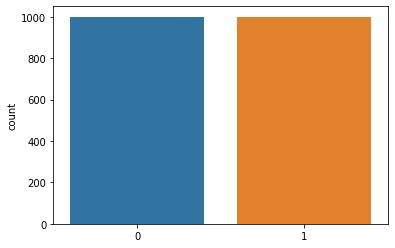

In [36]:
seaborn.countplot(validation_labels)

### Dataset Info

In [37]:
print(f"Training Images: {len(training_data)}\nValidation Images: {len(validation_data)}\nTesting Images: {len(testing_data)}")

Training Images: 10000
Validation Images: 2000
Testing Images: 5000


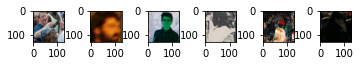

In [38]:
plot = matplot_plot.figure()
for index, image in enumerate(validation_data[:6]):
    plot.add_subplot(6, 6, index + 1)
    matplot_plot.imshow(image)
matplot_plot.show()


# Flatten the images into one numpy array

In [39]:
def create_model():
    model = keras.Sequential([
        keras.layers.Conv2D(32, 3, input_shape = [128, 128, 3], padding = "same", activation = "relu", name = "convolution_first"),
        keras.layers.Conv2D(32, 3, padding = "same", activation = "relu", name = "convolution_second"),
        keras.layers.MaxPool2D(pool_size = (2, 2), padding = "valid", name = "pooling_first"),
        keras.layers.Conv2D(64, 3, padding = "same", activation = "relu", name = "convolution_small_first"),
        keras.layers.Conv2D(64, 3, padding = "same", activation = "relu", name = "convolution_small_second"),
        keras.layers.MaxPool2D(pool_size = (2, 2), padding = "valid", name = "pooling_second"),
        keras.layers.Flatten(name = "flatten"),
        keras.layers.Dense(256, activation = "relu", name = "fully_connected_1"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation = "relu", name = "fully_connected_2"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, name = "classification"),
        keras.layers.Activation("sigmoid")
    ])
    model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.RMSprop(learning_rate=1e-4), metrics = [ "accuracy" ])
    return model


In [26]:
barnet = create_model()
barnet.summary()
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.acc.append(logs.get('accuracy'))
history = LossHistory()
callbacks = [
    history,
    keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, verbose = 1, mode = "auto")
]

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_first (Conv2D)   (None, 128, 128, 32)      896       
_________________________________________________________________
convolution_second (Conv2D)  (None, 128, 128, 32)      9248      
_________________________________________________________________
pooling_first (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
convolution_small_first (Con (None, 64, 64, 64)        18496     
_________________________________________________________________
convolution_small_second (Co (None, 64, 64, 64)        36928     
_________________________________________________________________
pooling_second (MaxPooling2D (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)            

# TRAIN!

In [40]:
barnet_history = barnet.fit(training_data, training_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (validation_data, validation_labels), verbose = 2, shuffle = True, callbacks = callbacks)

Epoch 1/50


In [ ]:
test_loss, test_accuracy = barnet.evaluate(testing_data, testing_labels, verbose = 1)
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}")

In [ ]:
matplot_plot.xlabel('Epochs')
matplot_plot.ylabel('Loss')
matplot_plot.title('Loss Trend')
matplot_plot.plot(history.losses, 'blue', label='Training Loss')
matplot_plot.plot(history.val_losses, 'green', label='Validation Loss')
matplot_plot.xticks(range(0,EPOCHS)[0::2])
matplot_plot.legend()
matplot_plot.show()

In [ ]:
matplot_plot.xlabel('Epochs')
matplot_plot.ylabel('Accuracy')
matplot_plot.title('Accuracy Trend')
matplot_plot.plot(history.acc, 'blue', label='Training Accuracy')
matplot_plot.plot(history.val_acc, 'green', label='Validation Accuracy')
matplot_plot.xticks(range(0,EPOCHS)[0::2])
matplot_plot.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
matplot_plot.legend()
matplot_plot.show()

# Calculate accuracy

In [ ]:
barnet.evaluate(testing_data, testing_labels, verbose = 1)